# Entrega 4 - Redes Neuronales

**Grupo 02:**

| Nombre         | C.I       | Email                        |
|----------------|-----------|------------------------------|
| Santiago Alaniz| 5082647-6 | santiago.alaniz@fing.edu.uy  |
| Bruno De Simone| 4914555-0 | bruno.de.simone@fing.edu.uy  |
| María Usuca    | 4891124-3 | maria.usuca@fing.edu.uy      |



## Objetivo

Considere **[Fashion-MNIST1](https://github.com/zalandoresearch/fashion-mnist/tree/master/data/fashion)**, un conjunto de datos con imágenes de 10 tipos diferentes de artículos de la empresa de vestimenta Zalando.

Este laboratorio busca desarrollar y optimizar un clasificador basado en redes neuronales para el dataset `Fashion-MNIST` de Zalando. Inicialmente, se establecerá una arquitectura base de red neuronal feedforward con parámetros específicos.

Posteriormente, se experimentará con tres arquitecturas adicionales para mejorar la clasificación. Al identificar el modelo más prometedor, se aplicarán técnicas de regularización y se comparará su rendimiento con benchmarks existentes. 

Finalmente, se identificarán las imágenes más desafiantes para el clasificador. 

Todo el desarrollo se realizará utilizando `PyTorch`, los resultados y análisis se presentarán en esta Jupyter Notebook.

In [ ]:
!pip3 install torch torchvision

### Carga de datos

Al dia de la fecha, dada la popularidad del dataset, muchas librerias han incorporado la carga de `Fashion-MNIST` como parte de su API.

`PyTorch` no es la excepción, la incluye en su libreria para datasets de visión artificial `torchvision`.

Particionamos los datos en dos conjuntos con `torch.utils.data.random_split` de la siguiente manera:

- `train` para entrenar el modelo.
- `eval` para evaluar el modelo.
- `test` para evaluar el modelo final.

Ademas, por cuestiones de reproducibilidad, se particiona el conjunto de entrenamiento en `train` y `val` con un generador determinado por una semilla.

##  Diseño

In [1]:
import torch
from torchvision import datasets
from torchvision.transforms import ToTensor

TEST_SIZE = 0.5
SEED_NUMBER = 42069

train = datasets.FashionMNIST('./data', train=True, download=True, transform= ToTensor())
test = datasets.FashionMNIST('./data', train=False, download=True, transform= ToTensor())

deterministic_generator = torch.Generator()
deterministic_generator.manual_seed(SEED_NUMBER)

test, eval = torch.utils.data.random_split(
    test, 
    [int(len(test) * (1-TEST_SIZE)), int(len(test) * TEST_SIZE)],
    generator=deterministic_generator
)

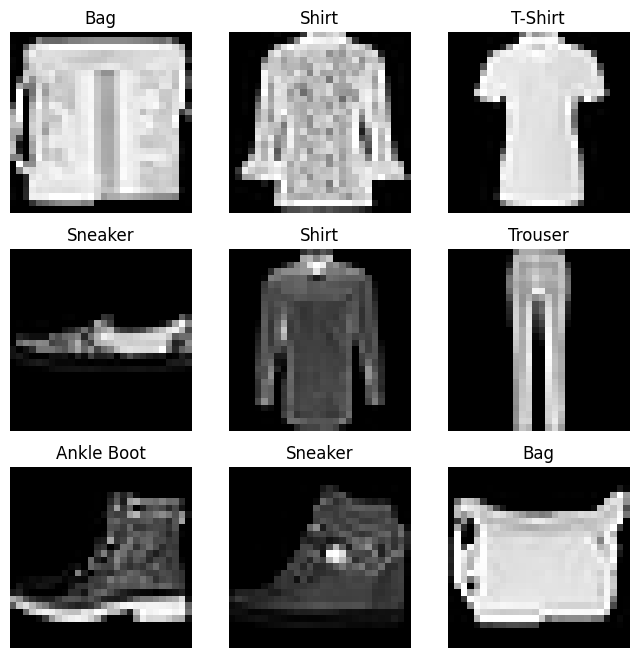

In [2]:
import matplotlib.pyplot as plt

LABELS = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3

for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train), size=(1,)).item()
    img, label = train[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(LABELS[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
    
plt.show()

### Preprocesamiento de datos

Para este laboratorio optamos por no relizar nosotros mismos el preprocesamiento, sino valernos de las herramientas que provee `Pytorch`. En particular [DataLoader](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html) nos permite preparar los datos para el entrenamiento de la red neuronal.

`DataLoader` actua como [wrapper](https://en.wikipedia.org/wiki/Wrapper_function)  de un dataset, permitiendo iterar sobre el mismo en batches de tamaño configurable. Además, permite realizar transformaciones sobre los datos, en nuestro caso, transformamos las imagenes a tensores.

In [3]:
from torch.utils.data import DataLoader

BATCH_SIZE = 64

train_dataloader = DataLoader(train, batch_size=BATCH_SIZE)
test_dataloader = DataLoader(test, batch_size=BATCH_SIZE)
eval_dataloader = DataLoader(eval, batch_size=BATCH_SIZE)

for X, y in train_dataloader:
    print("Shape of X [N, C, H, W]: ", X.shape)
    print("Shape of y: ", y.shape, y.dtype)
    break

Shape of X [N, C, H, W]:  torch.Size([64, 1, 28, 28])
Shape of y:  torch.Size([64]) torch.int64



### Algoritmo

Definimos la clase `NeuralNetwork` como una subclase de [torch.nn.Module](https://pytorch.org/docs/stable/generated/torch.nn.Module.html). La clase `NeuralNetwork` define la arquitectura de la red neuronal, y la clase Module de PyTorch nos permite utilizar la red neuronal definida en la clase NeuralNetwork para entrenarla y realizar predicciones. 

La arquitectura de la red neuronal es la siguiente:

* Capa de entrada (`fc1`): es una capa completamente conectada (o densa) que transforma la entrada de 784 (28*28) dimensiones a una representación intermedia de 32 dimensiones. 

* Capa oculta (`sigmoide`): esta capa utiliza la función sigmoide como función de activación.

* Capa de salida (`fc2`): hay 10 clases diferentes en el conjunto de datos Fashion-MNIST, por lo tanto, la capa de salida tiene 10 neuronas, una para cada clase.

En `PyTorch`, el concepto de `device` permite que los calculos se realicen en una CPU o GPU (si está disponible). Esto puede generar problemas dado que los tensores deben estar en el mismo dispositivo para poder operar con ellos. Por ejemplo, el conjunto de datos puede estar en la CPU, mientras que el modelo puede estar en la GPU. Para evitar este problema, se utiliza la función `to(DEVICE)` para mover los tensores a un dispositivo dado.

***Nota***

Una estrategia interesante en el caso de modelo(gpu) y datos(cpu) es agregar el argumento `pin_memory=True` al constructor de la clase `DataLoader`. Esto acelara la transmición de datos entre dispositivos, dado que se fijan las páginas de memoria en la RAM destinadas al almacenamiento de los datos. Este acercamiento asegura una transmición más rápida, pero utiliza más memoria RAM.

Lamentablemente, la clase `DataLoader` no permite cargar todos los datos directamente en la GPU, por lo que se debe utilizar el argumento `pin_memory=True` y luego mover los batches de datos a la GPU con `to(DEVICE)`.

Esto tiene sentido dado que la GPU tiene una memoria mucho más limitada que la RAM, en nuestro Fashion-MNIST cabe en una GPU moderna, pero obviamente no es el caso para datasets más grandes.

In [4]:
from src.neural_network import *

# Get cpu, gpu or mps device for training.
DEVICE = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {DEVICE} device")

model = NeuralNetwork().to(DEVICE)
print (model)

Using cpu device
NeuralNetwork(
  (fc1): Linear(in_features=784, out_features=32, bias=True)
  (sigmoid): Sigmoid()
  (fc2): Linear(in_features=32, out_features=10, bias=True)
)


In [ ]:
import matplotlib.pyplot as plt

# Obtener el primer lote del DataLoader
images, labels = next(iter(train_dataloader))

# Tomar la primera imagen y etiqueta del lote
single_image = images[0]
single_label = labels[0]

# Visualizar la imagen
plt.imshow(single_image[0].numpy(), cmap="gray")
plt.title(f"Etiqueta: {LABELS[single_label.item()]}")
plt.show()

single_image = single_image.to(DEVICE) 
# Pasar la imagen a través del modelo
output = model(single_image)
prediction = torch.argmax(output, dim=1)

print(f"Predicción del modelo: {LABELS[prediction.item()]}")

### Evaluación

```
- ii) Utilizando el conjunto de entrenamiento provisto, entrene a la red construida en el paso anterior durante 10 épocas
- iii) Evalúe el rendimiento del clasificador construido sobre un conjunto de validación, utilizando descenso por gradiente estocástico y una tasa de aprendizaje de 0.01.
- iv) Reporte gráficamente la evolución de la pérdida en el conjunto de entrenamiento y de la accuracy sobre el conjunto de validación en función de las iteraciones.
```

Entrenamos la red neuronal durante 10 épocas con el conjunto `train`, y evaluamos el rendimiento del clasificador sobre el conjunto `eval`. 

Para el entrenamiento utilizamos la función de pérdida de entropía cruzada, ya que es una buena opción para problemas de clasificación multiclase. Y se usa el descenso por gradiente estocástico (SGD) como nuestro optimizador, con una tasa de aprendizaje de 0.01.

In [ ]:
from src.train_and_test import train_model, test_model

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

epochs = 10

train_losses = []
eval_losses = []
train_accuracies = []
eval_accuracies = []
for t in range(epochs):
    print(f"Epoch {t+1}:")
    
    train_loss, train_acc = train_model(train_dataloader, model, loss_fn, optimizer, DEVICE)
    eval_loss, eval_acc = test_model(eval_dataloader, model, loss_fn, DEVICE)
    
    print(f"Train loss {train_loss}, Eval loss {eval_loss}, Train accuracy {train_acc}, Eval accuracy {eval_acc}\n-------------------------------")

    train_losses.append(train_loss)
    eval_losses.append(eval_loss)
    train_accuracies.append(train_acc)
    eval_accuracies.append(eval_acc)

A continuación se muestra la evolución de la pérdida en el conjunto de entrenamiento y de la accuracy sobre el conjunto de validación en función de las iteraciones.

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Entrenamiento', color='tab:red')
plt.plot(eval_losses, label='Validación', color='tab:orange')
plt.title('Evolución de la perdida')
plt.xlabel('Épocas')
plt.ylabel('Perdida')
plt.yscale('log')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Entrenamiento', color='tab:red')
plt.plot(eval_accuracies, label='Validación', color='tab:blue')
plt.title('Evolución de la precisión')
plt.xlabel('Épocas')
plt.ylabel('Precisión (%)')
plt.legend()
plt.tight_layout()
plt.show()


Se puede observar una mejora en la precisión y una disminución en la pérdida a medida que avanzan las épocas. Esto indica que el modelo está aprendiendo a clasificar mejor las imágenes de Fashion-MNIST.

El modelo alcanzó una precisión del 76,68% sobre el conjunto de validación. Lo cual es un buen resultado para un modelo base, este desempeño establece un punto de referencia para comparar con los modelos de los siguientes puntos.

## Experimentación

```
b) Proponga tres arquitecturas adicionales que busquen mejorar los resultados, modificando la cantidad de unidades, la cantidad de capas ocultas, y/o diferentes funciones de activación. Para cada una, evalúe su rendimiento sobre un conjunto de validación, con diferentes valores de tasa de aprendizaje. 

c) A partir del mejor modelo obtenido en b), sugiera y aplique algún mecanimo de regularización y vuelva a evaluar sobre el conjunto de validación, igual que en el paso anterior.

d) Con el mejor modelo obtenido luego de los pasos anteriores, evalúe su performance sobre el conjunto de evaluación utilizando accuracy, precision, recall y medida F1 para cada una de las clases. 

Construya la matriz de confusión. Comente los resultados y compare con los reportados en el sitio del dataset. 

e) Muestre las diez instancias del conjunto de evaluación más “difíciles” para el clasificador construido, utilizando como medida la entropía. Comente los resultados.
```

Vamos a definir tres arquitecturas adicionales:

**Arquitectura 1** 

`NeuralNetwork1` es una red neuronal con dos capas ocultas, la primera con 64 unidades y la segunda con 32 unidades. Ambas capas utilizan la función sigmoide como función de activación. 

* Propuesta: aumentar la complejidad del modelo para mejorar la precisión, agregando más unidades y capas ocultas, para que el modelo pueda aprender patrones más complejos.

**Arquitectura 2**

`NeuralNetwork2` es una red neuronal con una capa oculta de 64 unidades que utiliza la función sigmoide como función de activación.

* Propuesta: Reducir la complejidad al tener una única capa oculta puede ayudar a evitar el sobreajuste y a mejorar la convergencia en conjuntos de datos más pequeños.
  
**Arquitectura 3**

`NeuralNetwork3` es una red neuronal con una capa oculta de 32 unidades que utiliza la funcion ReLU como función de activación. 

* Propuesta: Ver los resultados al cambiar la función de activación de la capa oculta a ReLU, ya que es una función de activación más moderna y que suele dar buenos resultados.

En cada caso, se evalúa el rendimiento del clasificador sobre el conjunto de validación, utilizando diferentes valores de tasa de aprendizaje. Los resultados de estas evaluaciones se utilizarán para seleccionar la mejor arquitectura y parámetros de entrenamiento para nuestro problema.

In [5]:
from src.neural_network_3 import *
from src.neural_network_1 import *
from src.neural_network_2 import *

model1 = NeuralNetwork1().to(DEVICE)
model2 = NeuralNetwork2().to(DEVICE)
model3 = NeuralNetwork3().to(DEVICE)

print (model1)
print (model2)
print (model3)

NeuralNetwork1(
  (fc1): Linear(in_features=784, out_features=64, bias=True)
  (sigmoid1): Sigmoid()
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (sigmoid2): Sigmoid()
  (fc3): Linear(in_features=32, out_features=10, bias=True)
)
NeuralNetwork2(
  (fc1): Linear(in_features=784, out_features=64, bias=True)
  (sigmoid1): Sigmoid()
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)
NeuralNetwork3(
  (fc1): Linear(in_features=784, out_features=32, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=32, out_features=10, bias=True)
)


In [24]:
import os
from src.train_and_test import train_and_evaluate
import pandas as pd
TASA_APRENDIZAJE = [0.001, 0.01, 0.1, 0.5]
epochs = 10

loss_fn = nn.CrossEntropyLoss()

def results_to_csv(model,model_name):
    results_model = []
    for lr in TASA_APRENDIZAJE:
        optimizer = torch.optim.SGD(model.parameters(), lr=lr)         
        results = train_and_evaluate(epochs, loss_fn, optimizer, model, train_dataloader, eval_dataloader, lr,  DEVICE)
        results_model.append(results)
        print(f"Modelo {model_name} con tasa de aprendizaje {lr} terminado")
    print(f"Modelo {model_name} terminado")
    results = pd.concat(results_model)
    results.to_csv(f'data/{model_name}.csv', index=False)

if not os.path.exists('data/model1'): results_to_csv(model1, 'model1')
print('model1 done')
if not os.path.exists('data/model2'): results_to_csv(model2,'model2')
print('model2 done')
if not os.path.exists('data/model3'): results_to_csv(model3,'model3')
print('model3 done')


KeyboardInterrupt: 

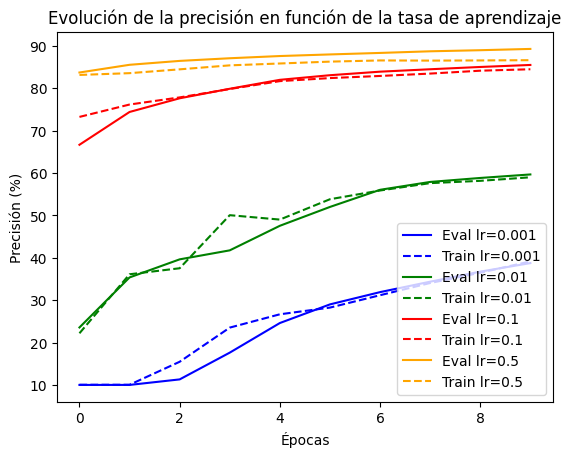

In [22]:
def plot_accuracy(model):
    results_csv = 'data/' + model + '.csv'
    results = pd.read_csv(results_csv)
    fig, ax = plt.subplots()
    colores = ['blue', 'green', 'red','orange']

    for i, lr in enumerate(TASA_APRENDIZAJE):
        subset = results[results['Tasa de aprendizaje'] == lr]
        epochs = subset['Epoch']
        eval_acc = subset['Train Accuracy']
        train_acc = subset['Eval Accuracy']

        ax.plot(epochs, eval_acc, label=f'Eval lr={lr}', color=colores[i])
        ax.plot(epochs, train_acc, label=f'Train lr={lr}', linestyle='--',color=colores[i])

    ax.set_xlabel('Épocas')
    ax.set_ylabel('Precisión (%)')
    ax.set_title('Evolución de la precisión en función de la tasa de aprendizaje')
    ax.legend()

    plt.show()
    
plot_accuracy('model1')

## Conclusión

## Bibliografia.

- [Tutorial de PyTorch](https://pytorch.org/tutorials/beginner/basics/intro.html)
- [Fashion-MNIST1](https://github.com/zalandoresearch/fashion-mnist/tree/master/data/fashion)